In [1]:
!ls

CodeT5.ipynb  PLBART.ipynb  Roberta.ipynb  data.jsonl  predictions_codet5.jsonl
Models	      PLBModels     codet5.png	   hubert.png


In [2]:
# !pip install transformers --force --ignore-installed PyYAML


In [3]:
# !pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 torchaudio==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html 


In [4]:
# from google.colab import drive
# drive.mount('/content/gdrive/')
# %cd /content/gdrive/Shareddrives/DL

In [5]:
import torch

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
import numpy as np
import torch
from transformers import RobertaTokenizer, RobertaConfig, RobertaModel, RobertaForSequenceClassification, BertTokenizer
from transformers import PLBartTokenizer, PLBartForConditionalGeneration
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from tqdm import tqdm

import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [7]:
tc2code = pd.read_json('./data.jsonl',lines=True)

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
print(tc2code.head())

                                            testCode  \
0  /*\n * This file was automatically generated b...   
1  /*\n * This file was automatically generated b...   
2  /*\n * This file was automatically generated b...   
3  /*\n * This file was automatically generated b...   
4  /*\n * This file was automatically generated b...   

                                          sourceCode  
0  package macaw.util;\n\nimport macaw.system.Mac...  
1  package macaw.util;\n\nimport macaw.system.Use...  
2  package macaw.util;\n\nimport java.util.regex....  
3  package macaw.util;\n\nimport java.awt.event.C...  
4  package macaw.util;\n\nimport javax.swing.*;\n...  


Random data Explorations

In [10]:
!pip install sentencepiece

In [11]:
from transformers import PLBartForConditionalGeneration, PLBartTokenizer, BartTokenizer
tokenizer = PLBartTokenizer.from_pretrained("uclanlp/plbart-base",src_lang="java", tgt_lang="java")
model = PLBartForConditionalGeneration.from_pretrained("uclanlp/plbart-base").to(device)
# model=T5Model.from_pretrained("Salesforce/codet5-small")
input_ids = tokenizer(
    tc2code['testCode'][0], return_tensors="pt"
).input_ids  # Batch size 1
decoder_input_ids = tokenizer(tc2code['sourceCode'][0], return_tensors="pt").input_ids  # Batch size 1

# forward pass
# outputs = model(input_ids=input_ids, decoder_input_ids=decoder_input_ids)
# last_hidden_states = outputs.last_hidden_state

In [12]:
sample_outputs = model.generate(
    input_ids.to(device),
    do_sample=True, 
    max_length=50, 
    top_k=50, 
    top_p=0.95, 
    num_return_sequences=3
)

# outputs = model.generate(input_ids)
print("Generated docstring:", tokenizer.decode(sample_outputs[0], skip_special_tokens=True))

Generated docstring: packagepackagepackagepackagepackagepackagepackagepackagepackagepackagepackagepackage packagepackagepackage package package package package package package package package package package packagepackage;package package package package;package package package packagePackage; }; package package package package package; package


In [13]:
model.cpu()
del model

Define Tokenizer and Tokenize the input and op

In [14]:
# tc2code['token_lengths']=tc2code['sourceCode'].apply(lambda x: len(tokenizer.tokenize(x)))

In [15]:
# tc2code['token_lengths_test']=tc2code['testCode'].apply(lambda x: len(tokenizer.tokenize(x)))

In [16]:
# tc2code['token_lengths'].describe()

The 75th percentile is 1766 hence we choose 1800 as the max_length

In [17]:
# tc2code['token_lengths_test'].describe()

The 75th percentile is 745 and 1351 so lets go with 1400 and 750

In [18]:
def PlBartTokenizerForSeq2Seq(x):
  targetSeq=tokenizer(x,max_length=1400,truncation=True,padding='max_length',return_tensors="pt", add_special_tokens = True).input_ids
    ## Regularize Cross Entropy loss
  #  target_seq_with_ignore_index=[]
  #  for seq in targetSeq:
  #     targetseq_example = [label if label != 0 else -100 for label in seq]
  #     target_seq_with_ignore_index.append(targetseq_example)
  #  return torch.Tensor(target_seq_with_ignore_index)
  targetSeq[targetSeq==0]=-100
  return targetSeq



In [19]:
def PLBartTokenizerForSeq2SeqTest(x):
  return tokenizer.batch_encode_plus(x,max_length=750,truncation=True,padding='max_length',return_tensors="pt", add_special_tokens = True)

In [20]:
print(PlBartTokenizerForSeq2Seq(tc2code['sourceCode'][0]))

tensor([[1886, 4615, 2358,  ...,    1,    1,    1]])


Report ඞ

In [21]:
sample_code=tc2code.head(10)
sample_code['test_Samples']=sample_code['testCode'].apply(lambda x: tokenizer.tokenize(x))
sample_code['source_Samples']=sample_code['sourceCode'].apply(lambda x: tokenizer.tokenize(x))
sample_code.head(10)

/home/harish/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/harish/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,testCode,sourceCode,test_Samples,source_Samples
0,/*\n * This file was automatically generated b...,package macaw.util;\n\nimport macaw.system.Mac...,"[▁/*, ▁*, ▁This, ▁file, ▁was, ▁automatically, ...","[▁package, ▁mac, aw, ., util, ;, ▁import, ▁mac..."
1,/*\n * This file was automatically generated b...,package macaw.util;\n\nimport macaw.system.Use...,"[▁/*, ▁*, ▁This, ▁file, ▁was, ▁automatically, ...","[▁package, ▁mac, aw, ., util, ;, ▁import, ▁mac..."
2,/*\n * This file was automatically generated b...,package macaw.util;\n\nimport java.util.regex....,"[▁/*, ▁*, ▁This, ▁file, ▁was, ▁automatically, ...","[▁package, ▁mac, aw, ., util, ;, ▁import, java..."
3,/*\n * This file was automatically generated b...,package macaw.util;\n\nimport java.awt.event.C...,"[▁/*, ▁*, ▁This, ▁file, ▁was, ▁automatically, ...","[▁package, ▁mac, aw, ., util, ;, ▁import, java..."
4,/*\n * This file was automatically generated b...,package macaw.util;\n\nimport javax.swing.*;\n...,"[▁/*, ▁*, ▁This, ▁file, ▁was, ▁automatically, ...","[▁package, ▁mac, aw, ., util, ;, ▁import, java..."
5,/*\n * This file was automatically generated b...,package macaw.util;\n\nimport macaw.businessLa...,"[▁/*, ▁*, ▁This, ▁file, ▁was, ▁automatically, ...","[▁package, ▁mac, aw, ., util, ;, ▁import, ▁mac..."
6,/*\n * This file was automatically generated b...,package macaw.util;\n\nimport macaw.system.Mac...,"[▁/*, ▁*, ▁This, ▁file, ▁was, ▁automatically, ...","[▁package, ▁mac, aw, ., util, ;, ▁import, ▁mac..."
7,/*\n * This file was automatically generated b...,/*\n * Created on 25-Jul-2009\n * Copyright (C...,"[▁/*, ▁*, ▁This, ▁file, ▁was, ▁automatically, ...","[▁/*, ▁*, ▁Created, ▁on, ▁25, -, J, ul, -200, ..."
8,/*\n * This file was automatically generated b...,package macaw.util;\n\nimport macaw.system.Mac...,"[▁/*, ▁*, ▁This, ▁file, ▁was, ▁automatically, ...","[▁package, ▁mac, aw, ., util, ;, ▁import, ▁mac..."
9,/*\n * This file was automatically generated b...,/*\n * Created on 25-Jul-2009\n * Copyright (C...,"[▁/*, ▁*, ▁This, ▁file, ▁was, ▁automatically, ...","[▁/*, ▁*, ▁Created, ▁on, ▁25, -, J, ul, -200, ..."


In [22]:
PLBartTokenizerForSeq2SeqTest(sample_code['testCode'].to_list())

{'input_ids': tensor([[ 4378,   294,   670,  ...,  4038,     2, 50001],
        [ 4378,   294,   670,  ...,  4346,     2, 50001],
        [ 4378,   294,   670,  ...,     1,     1,     1],
        ...,
        [ 4378,   294,   670,  ...,     1,     1,     1],
        [ 4378,   294,   670,  ...,   866,     2, 50001],
        [ 4378,   294,   670,  ...,   866,     2, 50001]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]])}

Training the models hopefully

In [23]:
X_train, X_test, y_train, y_test = train_test_split(tc2code['testCode'], tc2code['sourceCode'], test_size=0.2, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.1, shuffle=False)

In [24]:
X_train_tensors=PLBartTokenizerForSeq2SeqTest(X_train.to_list())
X_test_tensors=PLBartTokenizerForSeq2SeqTest(X_test.to_list())
X_val_tensors=PLBartTokenizerForSeq2SeqTest(X_val.to_list())

In [25]:
y_train_tensors=PlBartTokenizerForSeq2Seq(y_train.to_list())
y_test_tensors=PlBartTokenizerForSeq2Seq(y_test.to_list())
y_val_tensors=PlBartTokenizerForSeq2Seq(y_val.to_list())

In [26]:
input_ids_train = X_train_tensors['input_ids']
attention_masks_train = X_train_tensors['attention_mask']
labels_train = y_train_tensors

#validation set
input_ids_val = X_val_tensors['input_ids']
attention_masks_val = X_val_tensors['attention_mask']
labels_val = y_val_tensors


input_ids_test = X_test_tensors['input_ids']
attention_masks_test = X_test_tensors['attention_mask']
labels_test = y_test_tensors
expected_source_code=y_test.to_list()

In [27]:
expected_source_code[0]

'/*\n * Created on 14/mar/2010\n * Copyright (C) 2010 by Andrea Vacondio.\n *\n * This program is free software; you can redistribute it and/or modify it under the terms of the \n * GNU General Public License as published by the Free Software Foundation; \n * either version 2 of the License.\n * This program is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; \n * without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. \n * See the GNU General Public License for more details.\n * You should have received a copy of the GNU General Public License along with this program; \n * if not, write to the Free Software Foundation, Inc., \n *  59 Temple Place, Suite 330, Boston, MA 02111-1307 USA\n */\npackage org.pdfsam.guiclient.business.listeners;\n\nimport java.awt.event.InputEvent;\nimport java.awt.event.MouseWheelEvent;\nimport java.awt.event.MouseWheelListener;\n\nimport org.pdfsam.guiclient.gui.components.JPreviewImage;\n\n/**\n * 

In [28]:
import gc
gc.collect()

60

In [29]:
!ls 

CodeT5.ipynb  PLBART.ipynb  Roberta.ipynb  data.jsonl  predictions_codet5.jsonl
Models	      PLBModels     codet5.png	   hubert.png


Training the model

In [30]:
plb_model =  PLBartForConditionalGeneration.from_pretrained("uclanlp/plbart-base",max_position_embeddings=1500,ignore_mismatched_sizes=True).to(device)
plb_model.to(device)

Some weights of PLBartForConditionalGeneration were not initialized from the model checkpoint at uclanlp/plbart-base and are newly initialized because the shapes did not match:
- model.encoder.embed_positions.weight: found shape torch.Size([1026, 768]) in the checkpoint and torch.Size([1502, 768]) in the model instantiated
- model.decoder.embed_positions.weight: found shape torch.Size([1026, 768]) in the checkpoint and torch.Size([1502, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


PLBartForConditionalGeneration(
  (model): PLBartModel(
    (shared): Embedding(50005, 768, padding_idx=1)
    (encoder): PLBartEncoder(
      (embed_tokens): Embedding(50005, 768, padding_idx=1)
      (embed_positions): PLBartLearnedPositionalEmbedding(1502, 768)
      (layers): ModuleList(
        (0): PLBartEncoderLayer(
          (self_attn): PLBartAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (final_layer_norm): LayerNorm((768,)

In [31]:
dataset_train = TensorDataset(input_ids_train, 
                              attention_masks_train,
                              labels_train)

dataset_val = TensorDataset(input_ids_val, 
                             attention_masks_val, 
                             labels_val)

# dataset_test = TensorDataset(input_ids_test, 
#                              attention_masks_test, 
#                              labels_test)

Defining a Custom test loader

In [32]:

import torch
tr=torch.randn((2,3))
print(tr)
print(tr[0])

tensor([[ 0.0911,  0.5215, -0.4653],
        [ 1.5466,  1.4855,  1.1333]])
tensor([ 0.0911,  0.5215, -0.4653])


In [33]:
from torch.utils import data
class CodeTCDatasetTest(data.Dataset):
    def __init__(self, testTensor,sourceTensor,testExpectedCode):
      self.testTensor=testTensor
      self.sourceTensor=sourceTensor
      self.testExpectedCode=testExpectedCode


    def __getitem__(self, index):
        return self.testTensor[index],self.sourceTensor[index],self.testExpectedCode[index]


    def __len__(self):
        return len(self.testExpectedCode)


def collate_fn(data):
    testTensorList,sourceTensorList,sourceCode = zip(*data)

    testTensors = torch.stack(testTensorList, 0)
    sourceTensors = torch.stack(sourceTensorList, 0)
      
    return testTensors, sourceTensors, sourceCode

def get_test_loader(testTensor,sourceTensors,sourceCodeList,batch_size):
    code2tctest = CodeTCDatasetTest(testTensor,sourceTensors,sourceCodeList)
    data_loader = torch.utils.data.DataLoader(dataset=code2tctest, 
                                              batch_size=batch_size,
                                              collate_fn=collate_fn)
    return data_loader

In [34]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 8

#train set
dataloader_train = DataLoader(dataset_train,
                              sampler = RandomSampler(dataset_train),
                              batch_size = batch_size)

#validation set
dataloader_val = DataLoader(dataset_val,
                              sampler = RandomSampler(dataset_val),
                              batch_size = batch_size)

dataloader_test = get_test_loader(input_ids_test,labels_test,expected_source_code,batch_size)

In [35]:
from transformers import get_linear_schedule_with_warmup

optimizer = torch.optim.AdamW(plb_model.parameters(),
                 lr = 1e-4,
                 eps = 1e-8)
                 
epochs = 10

scheduler = get_linear_schedule_with_warmup(optimizer,
                                           num_warmup_steps = 0,
                                           num_training_steps = len(dataloader_train)*epochs)

In [36]:
def evaluate(dataloader_val,model):

    #evaluation mode 
    model.eval()
    
    #tracking variables
    loss_val_total = 0
    
    for batch in dataloader_val:
        
        #load into GPU
        batch = tuple(b.to(device) for b in batch)
        
        #define inputs
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2]}

        #compute logits
        with torch.no_grad():        
            outputs = model(**inputs)
        
        #compute loss
        loss = outputs[0]
        loss_val_total += loss.item()

    #compute average loss
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
            
    return loss_val_avg

In [37]:
def train_model(model,epochs):
    save_epoch=2
    validation_loss_epochs=[]
    training_loss_epochs=[]

    for epoch in tqdm(range(1, epochs+1)):
        
        model.train()
        
        loss_train_total = 0
        
#         progress_bar = tqdm(dataloader_train, 
#                             desc = 'Epoch {:1d}'.format(epoch), 
#                             leave = True, 
#                             disable = False)
        idx=0
        for batch in dataloader_train:
            idx+=1
            model.zero_grad() #set gradient to 0
        
            batch = tuple(b.to(device) for b in batch)
            
            inputs = {'input_ids': batch[0], 
                      'attention_mask': batch[1], 
                      'labels': batch[2]}
            
            outputs = model(**inputs) #unpack the dict straight into inputs
            
            loss = outputs[0]
            loss_train_total += loss.item()
            loss.backward()
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            
            optimizer.step()
            scheduler.step()
            
            if idx%300==0:
                print(f'training_loss at epoch:{epoch},iter:{idx}:{(loss.item() / len(batch))}')
#             progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item() / len(batch))})

        if epoch%save_epoch==0:    
          model.save_pretrained("PLBModels")
        
        tqdm.write(f'\n Epoch {epoch}')
        
        loss_train_ave = loss_train_total / len(dataloader_train)
        tqdm.write(f'Training loss: {loss_train_ave}')
        
        val_loss = evaluate(dataloader_val,model)
        validation_loss_epochs.append(val_loss)
        training_loss_epochs.append(loss_train_ave)
        
        tqdm.write(f'Validation loss: {val_loss}') 
    return validation_loss_epochs,training_loss_epochs,model

In [38]:
# print(epochs)

In [39]:
training_losses=[]
val_losses=[]

In [40]:
# plb_model.save_pretrained("PLBModels")

In [41]:
val_losses,training_losses,plb_model=train_model(plb_model,epochs)

  0%|          | 0/10 [00:00<?, ?it/s]

training_loss at epoch:1,iter:300:0.1506525973478953
training_loss at epoch:1,iter:600:0.24319936831792197
training_loss at epoch:1,iter:900:0.276054044564565
training_loss at epoch:1,iter:1200:0.14614349603652954
training_loss at epoch:1,iter:1500:0.10275261600812276
training_loss at epoch:1,iter:1800:0.13556523124376932
training_loss at epoch:1,iter:2100:0.07891931633154552


  0%|          | 0/10 [12:09<?, ?it/s]


 Epoch 1
Training loss: 0.6279618555168603


 10%|█         | 1/10 [13:02<1:57:19, 782.14s/it]

Validation loss: 0.3743462404038044
training_loss at epoch:2,iter:300:0.1726357340812683
training_loss at epoch:2,iter:600:0.045174395044644676
training_loss at epoch:2,iter:900:0.058949634432792664
training_loss at epoch:2,iter:1200:0.18641378482182822
training_loss at epoch:2,iter:1500:0.1775403618812561
training_loss at epoch:2,iter:1800:0.15718640883763632
training_loss at epoch:2,iter:2100:0.15624032417933145


 10%|█         | 1/10 [25:12<1:57:19, 782.14s/it]


 Epoch 2
Training loss: 0.39237714552428077


 20%|██        | 2/10 [26:05<1:44:23, 782.96s/it]

Validation loss: 0.3439561507198059
training_loss at epoch:3,iter:300:0.022785852352778118
training_loss at epoch:3,iter:900:0.11205741763114929
training_loss at epoch:3,iter:1200:0.12249306837717693
training_loss at epoch:3,iter:1500:0.20782033602396646
training_loss at epoch:3,iter:1800:0.15623363852500916
training_loss at epoch:3,iter:2100:0.061995421846707664


 20%|██        | 2/10 [38:13<1:44:23, 782.96s/it]


 Epoch 3
Training loss: 0.32490448909943564


 30%|███       | 3/10 [39:06<1:31:13, 781.90s/it]

Validation loss: 0.33111663308261213
training_loss at epoch:4,iter:300:0.18422450621922812
training_loss at epoch:4,iter:600:0.1806310017903646
training_loss at epoch:4,iter:900:0.055746336778004967
training_loss at epoch:4,iter:1200:0.0696517676115036
training_loss at epoch:4,iter:1800:0.13118488589922586
training_loss at epoch:4,iter:2100:0.03410762548446655


 30%|███       | 3/10 [51:18<1:31:13, 781.90s/it]


 Epoch 4
Training loss: 0.27914292609079666


 40%|████      | 4/10 [52:11<1:18:18, 783.00s/it]

Validation loss: 0.3315281868557404
training_loss at epoch:5,iter:300:0.137066384156545
training_loss at epoch:5,iter:600:0.0440295934677124
training_loss at epoch:5,iter:900:0.15394262472788492
training_loss at epoch:5,iter:1200:0.1005061666170756
training_loss at epoch:5,iter:1500:0.04036450386047363
training_loss at epoch:5,iter:1800:0.02459559092919032
training_loss at epoch:5,iter:2100:0.06791134675343831


 40%|████      | 4/10 [1:04:22<1:18:18, 783.00s/it]


 Epoch 5
Training loss: 0.2438264496474322
training_loss at epoch:6,iter:300:0.032660541435082756
training_loss at epoch:6,iter:600:0.11098462343215942
training_loss at epoch:6,iter:900:0.0903771420319875
training_loss at epoch:6,iter:1200:0.042743573586146034
training_loss at epoch:6,iter:1500:0.060361762841542564
training_loss at epoch:6,iter:1800:0.05576916038990021
training_loss at epoch:6,iter:2100:0.1003594199816386


 50%|█████     | 5/10 [1:17:23<1:05:17, 783.53s/it]


 Epoch 6
Training loss: 0.21535889246401607


 60%|██████    | 6/10 [1:18:16<52:10, 782.60s/it]  

Validation loss: 0.33445321971719916
training_loss at epoch:7,iter:300:0.05426227549711863
training_loss at epoch:7,iter:600:0.1289816896120707
training_loss at epoch:7,iter:900:0.04447086652119955
training_loss at epoch:7,iter:1200:0.04765619337558746
training_loss at epoch:7,iter:1500:0.07080814242362976
training_loss at epoch:7,iter:1800:0.07564220825831096
training_loss at epoch:7,iter:2100:0.045527552564938865


 60%|██████    | 6/10 [1:30:24<52:10, 782.60s/it]


 Epoch 7
Training loss: 0.19169393998848716


 70%|███████   | 7/10 [1:31:16<39:05, 781.98s/it]

Validation loss: 0.34012402285690235
training_loss at epoch:8,iter:300:0.04583653807640076
training_loss at epoch:8,iter:600:0.010975826531648636
training_loss at epoch:8,iter:900:0.06703780591487885
training_loss at epoch:8,iter:1200:0.030110254883766174
training_loss at epoch:8,iter:1500:0.008032325655221939
training_loss at epoch:8,iter:1800:0.06284602483113606
training_loss at epoch:8,iter:2100:0.15411922335624695


 70%|███████   | 7/10 [1:43:28<39:05, 781.98s/it]


 Epoch 8
Training loss: 0.17221047214611812


 80%|████████  | 8/10 [1:44:21<26:05, 782.70s/it]

Validation loss: 0.3508453625947871
training_loss at epoch:9,iter:300:0.04823986689249674
training_loss at epoch:9,iter:600:0.04047358532746633
training_loss at epoch:9,iter:900:0.1039048433303833
training_loss at epoch:9,iter:1200:0.04580524563789368
training_loss at epoch:9,iter:1500:0.0196118267873923
training_loss at epoch:9,iter:1800:0.07787664731343587
training_loss at epoch:9,iter:2100:0.04134619484345118


 80%|████████  | 8/10 [1:56:33<26:05, 782.70s/it]


 Epoch 9
Training loss: 0.15669535473476048


 90%|█████████ | 9/10 [1:57:26<13:03, 783.43s/it]

Validation loss: 0.3546604521759935
training_loss at epoch:10,iter:300:0.034513793885707855
training_loss at epoch:10,iter:600:0.0403887207309405
training_loss at epoch:10,iter:900:0.014178141951560974
training_loss at epoch:10,iter:1200:0.06092956165472666
training_loss at epoch:10,iter:1500:0.05063860615094503
training_loss at epoch:10,iter:1800:0.09276092052459717
training_loss at epoch:10,iter:2100:0.005995887021223704


 90%|█████████ | 9/10 [2:09:35<13:03, 783.43s/it]


 Epoch 10
Training loss: 0.145367099799232


100%|██████████| 10/10 [2:10:27<00:00, 782.78s/it]

Validation loss: 0.3595451210666902


In [42]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

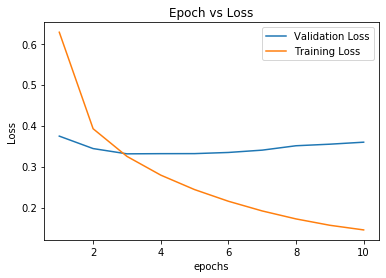

In [43]:

n_epochs=len(training_losses)

epochs_arr=np.arange(start=1,stop=n_epochs+1,step=1)
import matplotlib.pyplot as plt

plt.plot(epochs_arr,val_losses,label='Validation Loss')
plt.plot(epochs_arr,training_losses,label='Training Loss')

plt.xlabel('epochs')
plt.ylabel('Loss')

plt.title('Epoch vs Loss')
plt.legend()
plt.savefig('plbart.png')

In [44]:
def getPredictionsTopK(inputs,model,device):
      sample_outputs = model.generate(
        inputs.to(device),
        do_sample=True, 
        max_length=1800, 
        top_k=900, 
        top_p=0.95, 
        num_return_sequences=3)
    # outputs = model.generate(input_ids)
      sequences=[]
      for i in range(sample_outputs.shape[0]):
        sequences.append(tokenizer.decode(sample_outputs[i], skip_special_tokens=True))
      return sequences

def getPredictionsGreedy(inputs,model,device):
      greedy_output = model.generate(inputs.to(device), max_length=1800)
      sequences=[]
      for i in range(greedy_output.shape[0]):
        sequences.append(tokenizer.decode(greedy_output[i], skip_special_tokens=True))
      return sequences




In [45]:
def getPredictedTexts(dataloader_test,genAlgo,model,device):
    predictions=[]
    allExpectedprogs=[]
    idx=0
    for ip,eop,estr in dataloader_test:
        print(f"iter{idx} of {len(dataloader_test)}")
        prediction=genAlgo(ip,model,device)
        predictions=predictions+prediction
        expected=[x for x in estr]
        allExpectedprogs=allExpectedprogs+expected
        idx+=1
    return allExpectedprogs,predictions

In [47]:
allExpectedprogsGreedy,predictionsGreedy=getPredictedTexts(dataloader_test,getPredictionsGreedy,plb_model,device)

iter0 of 58


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [ ]:
predictiondf_t5 = pd.DataFrame(list(zip(allExpectedprogsGreedy, predictionsGreedy)), columns =['Expected', 'predictions']) 

In [ ]:
predictiondf_t5.to_json('./predictions_plbart.jsonl',orient='records', lines=True)

In [ ]:
!ls

In [ ]:
plb_model.save_pretrained("PLBModels")